# RPN Results and R-CNN Targets

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from config.config import Config
from src.data_generator import VOCData
from src.visualize import draw_box
from src.model import (get_rcnn_target, generate_anchors, get_rpn_target,
                       unparameterize_box, parameterize_box, box_iou,
                       yxyx_to_xyctrwh, xyctrwh_to_yxyx)

# increase image resolution for jupyter notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

## Load Configuration

In [2]:
# load config
config = Config()

Configuration is loaded: 
{'LR': 0.0001, 'DECAY': 0.0005, 'BATCH_SIZE': 8, 'EPOCH': 10000, 'DETECTION_NMS_IOU': 0.5, 'DETECTION_NMS_MAX_NUM': 100, 'INPUT_SHAPE': [600, 1000, 3], 'NUM_CLASS': 20, 'MAX_GT_INSTANCE': 50, 'BACKBONE': None, 'FEATURE_SHAPE': [37, 62], 'ANCHOR_NUM': 9, 'ANCHOR_SCALES': [128, 256, 512], 'ANCHOR_RATIOS': [0.5, 1.0, 2.0], 'FEATRUE_STRIDE': 16, 'ANCHOR_STRIDE': 1, 'RPN_POS_IOU_THOLD': 0.7, 'RPN_NEG_IOU_THOLD': 0.3, 'RPN_TOTAL_SAMPLE_NUM': 256, 'RPN_POS_SAMPLE_RATIO': 0.5, 'RPN_LAMBDA': 10.0, 'RPN_NMS_NUM': 2000, 'RPN_NMS_IOU': 0.7, 'RCNN_ROI_POOL_SIZE': 7, 'RCNN_POS_IOU_THOLD': 0.5, 'RCNN_NEG_IOU_THOLD': 0.1, 'RCNN_TOTAL_SAMPLE_NUM': 64, 'RCNN_POS_SAMPLE_RATIO': 0.25, 'RCNN_LAMDA': 1.0}


## Load Validation Dataset
> Note: Because training on the entire data set has not been done yet, only the `DEBUG` mode is provided. 

In [3]:
# load dataset
# test_data_dir = 'dataset/VOC2007/test/VOCdevkit/VOC2007'
test_data_dir = 'dataset/VOC2007/trainval/VOCdevkit/VOC2007'
test_dataset = VOCData(test_data_dir,
                        config.INPUT_SHAPE,
                        batch_size=config.BATCH_SIZE,
                        max_gt_instance=config.MAX_GT_INSTANCE,
                        debug=True)

Load from: dataset/VOC2007/trainval/VOCdevkit/VOC2007
DEBUD MODE: True
Batch size: 8
Images: 8
Classes: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']



## Load Trained Faster R-CNN model
> Note: This model is onverfitted with only 8 images.

In [4]:
# saved model dir
model_dir = 'model/20210819-170020-debug'
model = tf.keras.models.load_model(model_dir)
model.summary()


{}

Model: "faster_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 1000, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 600, 1000, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 600, 1000, 64 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 300, 500, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________

## Choose Data Point Index
If you want see different results from the other image, change the `idx` parameter in range [0, 7]

In [5]:
# data point
idx = 5
print("{} th image results.".format(idx))

5 th image results.


## R-CNN(Detection) Network Targets
### 1. Get RPN outputs from the network

In [6]:
# pick one data point from the test dataset
img_batch, (gt_cls_ids_batch, gt_boxes_batch, num_gt_instance_batch) = test_dataset[0]

img_batch = img_batch[idx:idx+1]
gt_cls_ids_batch = gt_cls_ids_batch[idx:idx+1]
gt_boxes_batch = gt_boxes_batch[idx:idx+1]
num_gt_instance_batch = num_gt_instance_batch[idx:idx+1]

# get output from the image
outputs = model(img_batch, training=False)

# unpack outputs
rpn_cls_output = outputs[0]  # [num of anchors, 2]
rpn_reg_output = outputs[1]  # [num of anchors, 4]

# convert `tf.tensor` to `np.ndarray`
rpn_cls_output = rpn_cls_output[0].numpy()
rpn_reg_output = rpn_reg_output[0].numpy()

# print shape of outputs
print("# of anchors = feature_map_height({}) x feature_map_width({}) x num_anchors({}): {}".format(
    config.FEATURE_SHAPE[0],
    config.FEATURE_SHAPE[1],
    config.ANCHOR_NUM,
    config.FEATURE_SHAPE[0]*config.FEATURE_SHAPE[1]*config.ANCHOR_NUM))
print("[RESULT] `rpn_cls_output` shape: ", rpn_cls_output.shape)
print("[RESULT] `rpn_reg_output` shape: ", rpn_reg_output.shape)

# of anchors = feature_map_height(37) x feature_map_width(62) x num_anchors(9): 20646
[RESULT] `rpn_cls_output` shape:  (20646, 2)
[RESULT] `rpn_reg_output` shape:  (20646, 4)


### 2. Unparamterize and clip rpn outputs and sort by scores

In [7]:
# generate anchor
anchors = generate_anchors(
    config.ANCHOR_SCALES,
    config.ANCHOR_RATIOS,
    config.FEATURE_SHAPE,
    config.FEATRUE_STRIDE,
    config.ANCHOR_STRIDE
    )

# unparam box
roi_boxes = unparameterize_box(rpn_reg_output, yxyx_to_xyctrwh(anchors))
roi_boxes = xyctrwh_to_yxyx(roi_boxes)
roi_boxes = roi_boxes.numpy()
roi_boxes = np.clip(
    roi_boxes,
    [0,0,0,0],
    [config.INPUT_SHAPE[0]-1, config.INPUT_SHAPE[1]-1, config.INPUT_SHAPE[0]-1, config.INPUT_SHAPE[1]-1,])
print("[RESULT] Before unparameterize rpn_reg_output: {}".format(rpn_reg_output[0]))
print("[RESULT] After unparameterize rpn_reg_output [y_min, x_min, y_max, y_min]: {}".format(roi_boxes[0]))

# get score from rpn cls output(probability)
roi_scores = rpn_cls_output[:, 1]

# sort by scores
order = np.argsort(roi_scores)[::-1]
sorted_roi_scores = roi_scores[order]
sorted_roi_boxes = roi_boxes[order]
sorted_anchors = anchors[order]
sorted_rpn_reg_output = rpn_reg_output[order]


[RESULT] Before unparameterize rpn_reg_output: [ 0.23897113 -0.37804595  0.97353107 -0.3031914 ]
[RESULT] After unparameterize rpn_reg_output [y_min, x_min, y_max, y_min]: [  0.           0.           6.40393829 149.43121338]



### 3. Visualize top-k RoIs and NMS RoIs

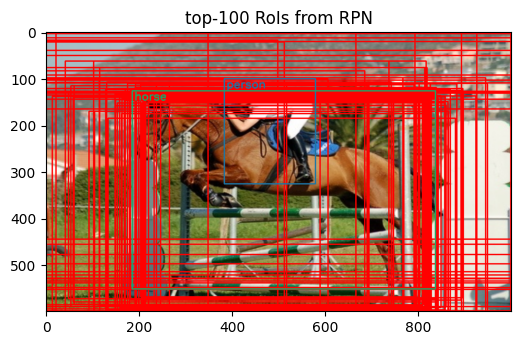

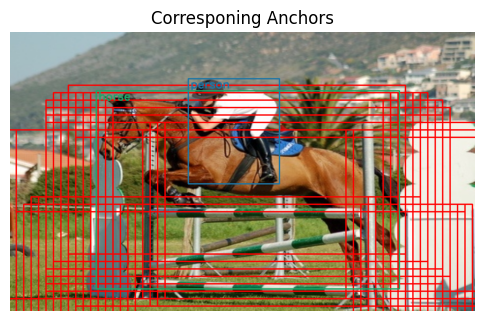

In [8]:
# number of top k
top_k = 100

# draw top-k RoIs
roi_img = img_batch[0].copy()
for roi_box in sorted_roi_boxes[:top_k]:
    roi_img = draw_box(roi_img, roi_box, color=[0,0,255])
# label ground truth bounding boxes
roi_img = test_dataset.draw_label_img(
    roi_img,
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.title('top-{} RoIs from RPN'.format(top_k))
plt.imshow(roi_img)
plt.show()

# draw corresponding anchors
anchor_img = img_batch[0].copy()
for anchor in sorted_anchors[:top_k]:
    anchor_img = draw_box(anchor_img, anchor, color=[0,0,255])
# label ground truth bounding boxes
anchor_img = test_dataset.draw_label_img(
    anchor_img,
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.axis('off')
plt.title('Corresponing Anchors'.format(top_k))
plt.imshow(anchor_img)
plt.show()

### 4. Non-Maximum Suppression for RPN RoIs

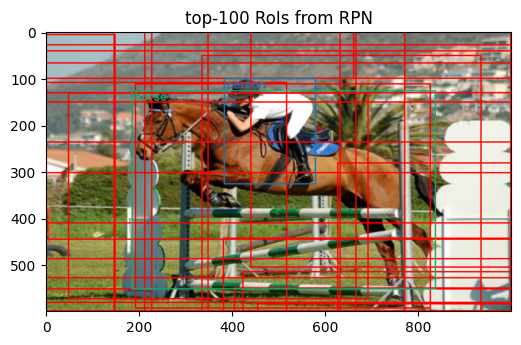

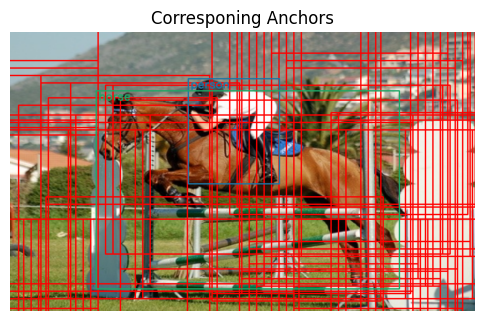

In [9]:
# number of top k
top_k = 100

# NMS
selected_indices = tf.image.non_max_suppression(
    roi_boxes,
    roi_scores,
    max_output_size=config.RPN_NMS_NUM,
    iou_threshold=config.RPN_NMS_IOU,
).numpy()
selected_roi_boxes = roi_boxes[selected_indices]
selected_roi_scores = roi_scores[selected_indices]
selected_anchors = anchors[selected_indices]

# draw top-k RoIs
nms_roi_img = img_batch[0].copy()
for roi_box in selected_roi_boxes[:top_k]:
    nms_roi_img = draw_box(nms_roi_img, roi_box, color=[0,0,255])
# label ground truth bounding boxes
nms_roi_img = test_dataset.draw_label_img(
    nms_roi_img,
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.title('top-{} RoIs from RPN'.format(top_k))
plt.imshow(nms_roi_img)
plt.show()

# draw corresponding anchors
anchor_img = img_batch[0].copy()
for anchor in selected_anchors[:top_k]:
    anchor_img = draw_box(anchor_img, anchor, color=[0,0,255])
# label ground truth bounding boxes
anchor_img = test_dataset.draw_label_img(
    anchor_img,
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.axis('off')
plt.title('Corresponing Anchors'.format(top_k))
plt.imshow(anchor_img)
plt.show()

### 5. Calculate R-CNN targets

In [10]:
# unparam box
selected_roi_boxes = selected_roi_boxes.astype(np.float32)
targets = get_rcnn_target(selected_roi_boxes,
                          gt_boxes_batch[0][:num_gt_instance_batch[0]],
                          gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
                          len(selected_anchors),
                          pos_threshold=config.RCNN_POS_IOU_THOLD,
                          neg_threshold=config.RCNN_NEG_IOU_THOLD,
                          total_sample_num=config.RCNN_TOTAL_SAMPLE_NUM,
                          pos_sample_ratio=config.RCNN_POS_SAMPLE_RATIO)

# print R-CNN configurations
print("[CONFIG] positive IoU threshold: {}".format(config.RCNN_POS_IOU_THOLD))
print("[CONFIG] negative IoU threshold: {}".format(config.RCNN_NEG_IOU_THOLD))
print("[CONFIG] number of total sample: {}".format(config.RCNN_TOTAL_SAMPLE_NUM))
print("[CONFIG] positive/neative ratio: {}\n".format(config.RCNN_POS_SAMPLE_RATIO))

# unpack outputs
rcnn_cls_target = targets[0].numpy()
rcnn_reg_target = targets[1].numpy()
rcnn_train_indices = targets[2].numpy()
rcnn_valid_train_num = targets[3].numpy()
rcnn_sampled_pos_num = targets[4].numpy()

print("[RESULT] rcnn_cls_target shape: {}".format(rcnn_cls_target.shape))
print("[RESULT] rcnn_reg_target shape: {}".format(rcnn_reg_target.shape))
print("[RESULT] rcnn_train_indices: {}".format(rcnn_train_indices))
print("[RESULT] # of rcnn_valid_train_num: {}".format(rcnn_valid_train_num))
print("[RESULT] # of rcnn_sampled_pos_num: {}".format(rcnn_sampled_pos_num))

[CONFIG] positive IoU threshold: 0.5
[CONFIG] negative IoU threshold: 0.1
[CONFIG] number of total sample: 64
[CONFIG] positive/neative ratio: 0.25

[RESULT] rcnn_cls_target shape: (64,)
[RESULT] rcnn_reg_target shape: (64, 4)
[RESULT] rcnn_train_indices: [1475    1 1723   22    4 1884   12    0 1950   15 1355 1614 1605    3
 1827   24 1633 1582 1558    6 1357 1263    9 1330 1935 1629 1370 1609
 1815 1293 1543 1940 1274 1880 1271 1972 1272 1615 1237   16   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1]
[RESULT] # of rcnn_valid_train_num: 40
[RESULT] # of rcnn_sampled_pos_num: 10


### 6. Visualize R-CNN Targets

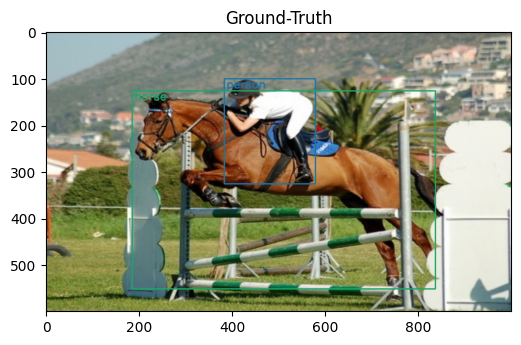

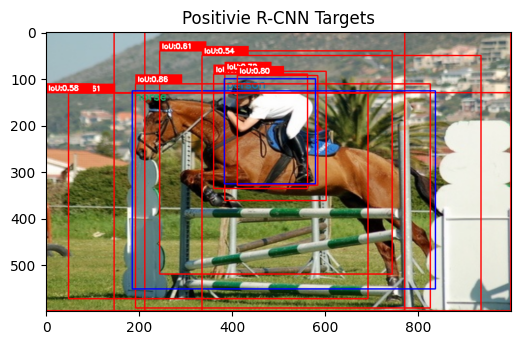

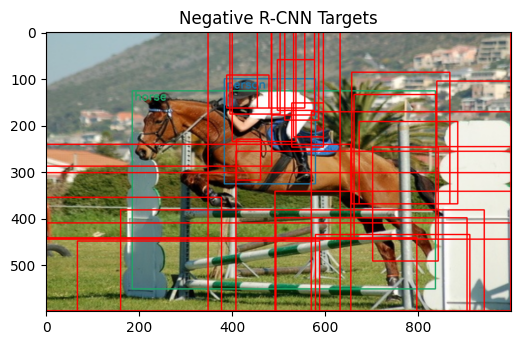

In [11]:
# get positivie target boxes
pos_target_deltas = rcnn_reg_target[:rcnn_sampled_pos_num]
pos_roi_boxes = selected_roi_boxes[rcnn_train_indices[:rcnn_sampled_pos_num]]

# unparamterize boxes
pos_target_boxes = unparameterize_box(
    pos_target_deltas.astype(np.float32),
    yxyx_to_xyctrwh(pos_roi_boxes))
pos_target_boxes = xyctrwh_to_yxyx(pos_target_boxes)

# label ground truth bounding boxes
gt_box_img = test_dataset.draw_label_img(
    img_batch[0],
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.imshow(gt_box_img)
plt.title("Ground-Truth")
plt.show()


# draw positive rcnn targets
pos_rcnn_target_img = gt_box_img.copy()
target_roi_boxes = zip(pos_target_boxes, pos_roi_boxes)
for target_box, roi_box in target_roi_boxes:
    iou = box_iou(
        np.expand_dims(target_box, axis=0),
        np.expand_dims(roi_box, axis=0))[0][0]
    pos_rcnn_target_img = draw_box(pos_rcnn_target_img, target_box, color=[0,0,255])
    pos_rcnn_target_img = draw_box(pos_rcnn_target_img, roi_box, "IoU:{:.2f}".format(iou))
plt.imshow(pos_rcnn_target_img)
plt.title("Positivie R-CNN Targets")
plt.show()

# get negative roi boxes
neg_roi_boxes = selected_roi_boxes[rcnn_train_indices[rcnn_sampled_pos_num:]]
neg_rcnn_target_img = gt_box_img.copy()
for neg_roi_box in neg_roi_boxes:
    neg_rcnn_target_img = draw_box(neg_rcnn_target_img, neg_roi_box, color=[255,0,0])
plt.imshow(neg_rcnn_target_img)
plt.title("Negative R-CNN Targets")
plt.show()

# [DEBUG] Calcuate R-CNN Targets From `Region Proposal Layer`

In [12]:
# get output from the image
outputs = model(img_batch, training=False)

# unpack outputs
roi_boxes = outputs[4]  # [N, 4]
valid_num = outputs[5]  # []

# get targets
targets = get_rcnn_target(roi_boxes,
                          gt_boxes_batch[0][:num_gt_instance_batch[0]],
                          gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
                          valid_num[0],
                          pos_threshold=config.RCNN_POS_IOU_THOLD,
                          neg_threshold=config.RCNN_NEG_IOU_THOLD,
                          total_sample_num=config.RCNN_TOTAL_SAMPLE_NUM,
                          pos_sample_ratio=config.RCNN_POS_SAMPLE_RATIO)

# unpack outputs
rcnn_cls_target = targets[0].numpy()
rcnn_reg_target = targets[1].numpy()
rcnn_train_indices = targets[2].numpy()
rcnn_valid_train_num = targets[3].numpy()
rcnn_sampled_pos_num = targets[4].numpy()

print("[RESULT] rcnn_cls_target shape: {}".format(rcnn_cls_target.shape))
print("[RESULT] rcnn_reg_target shape: {}".format(rcnn_reg_target.shape))
print("[RESULT] rcnn_train_indices: {}".format(rcnn_train_indices))
print("[RESULT] # of rcnn_valid_train_num: {}".format(rcnn_valid_train_num))
print("[RESULT] # of rcnn_sampled_pos_num: {}".format(rcnn_sampled_pos_num))

[RESULT] rcnn_cls_target shape: (64,)
[RESULT] rcnn_reg_target shape: (64, 4)
[RESULT] rcnn_train_indices: [1475    0 1884    1   12 1723 1950   22   15    4   20    5   16 1384
   33    9 1815 1355 1757 1614 1847 1370 1605 1463 1252 1271 1838 1677
 1940    7 1609 1582 1910 1827 1237 1615 1972 1543 1520 1330   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1
   -1   -1   -1   -1   -1   -1   -1   -1]
[RESULT] # of rcnn_valid_train_num: 40
[RESULT] # of rcnn_sampled_pos_num: 10


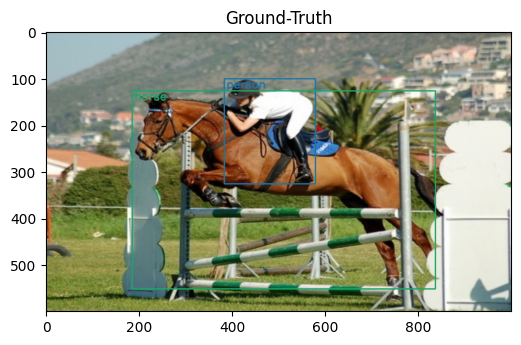

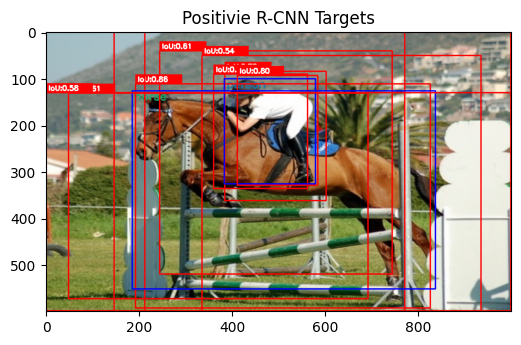

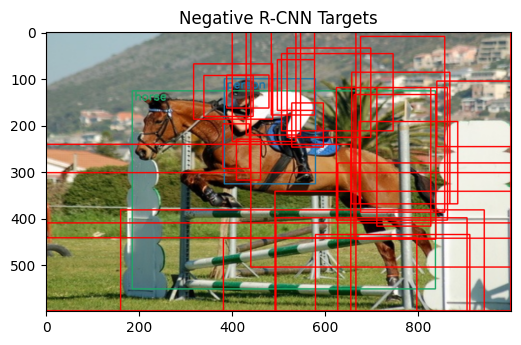

In [13]:

# get positivie target boxes
roi_boxes = np.array(roi_boxes, dtype=np.float32)
pos_target_deltas = rcnn_reg_target[:rcnn_sampled_pos_num]
pos_roi_boxes = roi_boxes[rcnn_train_indices[:rcnn_sampled_pos_num]]

# unparamterize boxes
pos_target_boxes = unparameterize_box(
    pos_target_deltas.astype(np.float32),
    yxyx_to_xyctrwh(pos_roi_boxes))
pos_target_boxes = xyctrwh_to_yxyx(pos_target_boxes)

# 1) show ground truth bounding boxes
gt_box_img = test_dataset.draw_label_img(
    img_batch[0],
    gt_cls_ids_batch[0][:num_gt_instance_batch[0]],
    gt_boxes_batch[0][:num_gt_instance_batch[0]])
plt.imshow(gt_box_img)
plt.title("Ground-Truth")
plt.show()

# 2) show positive rcnn targets
pos_rcnn_target_img = gt_box_img.copy()
target_roi_boxes = zip(pos_target_boxes, pos_roi_boxes)
for target_box, roi_box in target_roi_boxes:
    iou = box_iou(
        np.expand_dims(target_box, axis=0),
        np.expand_dims(roi_box, axis=0))[0][0]
    pos_rcnn_target_img = draw_box(pos_rcnn_target_img, target_box, color=[0,0,255])
    pos_rcnn_target_img = draw_box(pos_rcnn_target_img, roi_box, "IoU:{:.2f}".format(iou))
plt.imshow(pos_rcnn_target_img)
plt.title("Positivie R-CNN Targets")
plt.show()

# 3) show negative roi boxes
neg_roi_boxes = roi_boxes[rcnn_train_indices[rcnn_sampled_pos_num:]]
neg_rcnn_target_img = gt_box_img.copy()
for neg_roi_box in neg_roi_boxes:
    neg_rcnn_target_img = draw_box(neg_rcnn_target_img, neg_roi_box, color=[255,0,0])
plt.imshow(neg_rcnn_target_img)
plt.title("Negative R-CNN Targets")
plt.show()
